In [1]:
import time
import os
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/61_inch/focus_tim

/Users/tim/MMT/61_inch/focus_tim


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [335]:
##### intra_whole = fits.open("cwfs_0002.fits")[2].data # focus = 2200
extra_whole = fits.open("cwfs_0004.fits")[2].data # focus = 2800
#intra = intra_whole[942-18:942+18,158-18:158+18] - np.median(intra_whole)
#extra = extra_whole[945-18:945+18,154-18:154+18] - np.median(extra_whole)
intra = intra_whole[803-18:803+18,182-18:182+18] - np.median(intra_whole)
extra = extra_whole[806-18:806+18,185-18:185+18] - np.median(extra_whole)

<IPython.core.display.Javascript object>


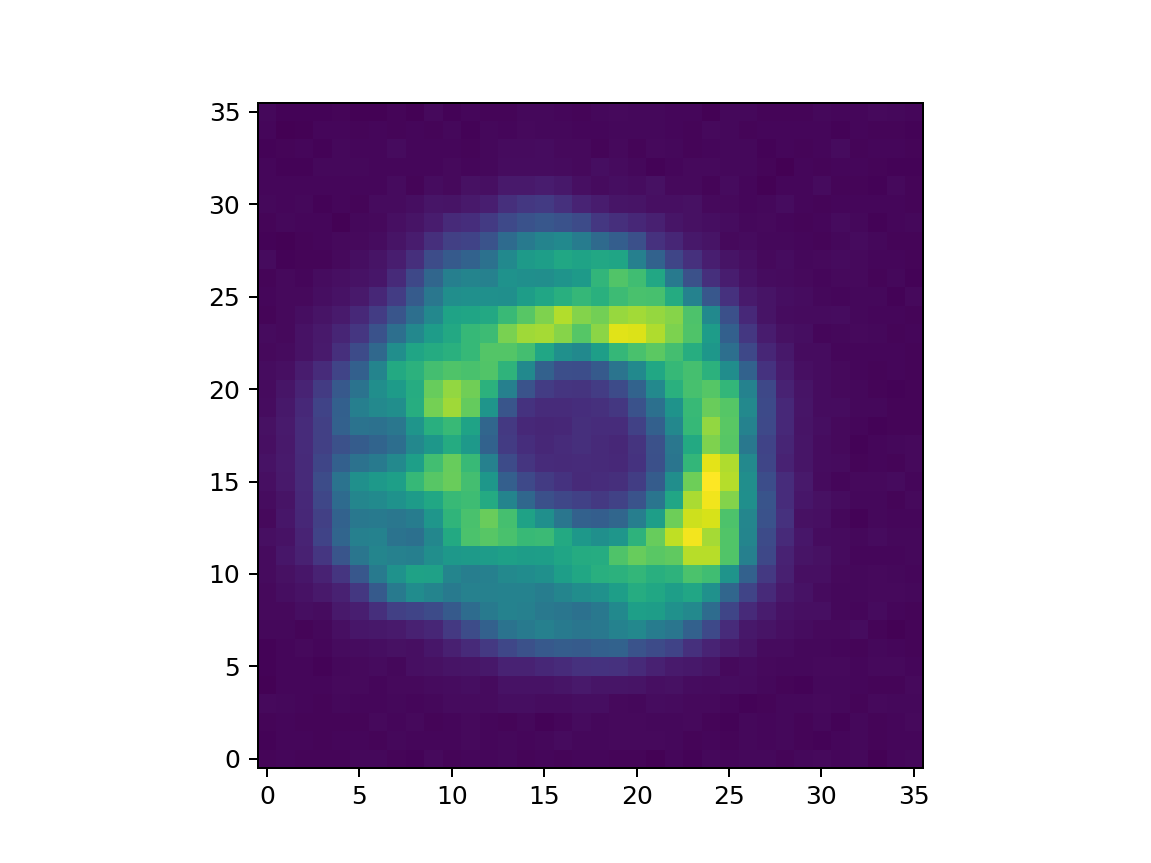

In [338]:
#plt.imshow(intra_whole[942-20:942+20,158-20:158+20], origin="lower")
#plt.imshow(extra_whole[945-20:945+20,154-20:154+20], origin="lower")
plt.imshow(extra, origin="lower")
plt.show()

In [339]:
fits.writeto("intra.fits", intra, overwrite=True)
fits.writeto("extra.fits", extra, overwrite=True)

These images are binned 3x3 so the pixels are 45 um. Thus the pupil diameter is:

In [315]:
pupsize = 14 * 3 * 25
pupsize * u.um

<Quantity 1050. um>

The mirror diameter is 1.54 meters and the focal ratio is 13.5. So the focal length is:

In [316]:
diameter = 1.54 * u.m
radius = diameter / 2.
focal_length = diameter * 13.5
focal_length

<Quantity 20.79 m>

Calculate the angle of beam convergence:

In [317]:
ang = np.arctan2(radius, focal_length)
ang

<Quantity 0.03702012 rad>

In [318]:
offset = 0.5 * pupsize / np.tan(ang) * u.um
offset

<Quantity 14175. um>

So about 14 mm of focus offset at focal plane for 300 counts of focus change which gives 20 counts/mm. For motion at the secondary, scale by the ratio of the squares of the focal ratios:

In [249]:
counts_per_mm = 300. / offset.to(u.mm).value
counts_per_mm_m2 = counts_per_mm / (13.5**2 / 4.**2)
counts_per_mm_m2

1.7341529915832616

In [250]:
obscuration = 0.4096 / 1.54
obscuration

0.265974025974026

In [251]:
nmperrad = radius.to(u.nm).value
nmperasec = nmperrad / 206265.
nmperasec

3733.061837926938

In [340]:
fieldXY = [0., 0.]
I1 = Image(readFile("intra.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("extra.fits"), fieldXY, Image.EXTRA)

<IPython.core.display.Javascript object>


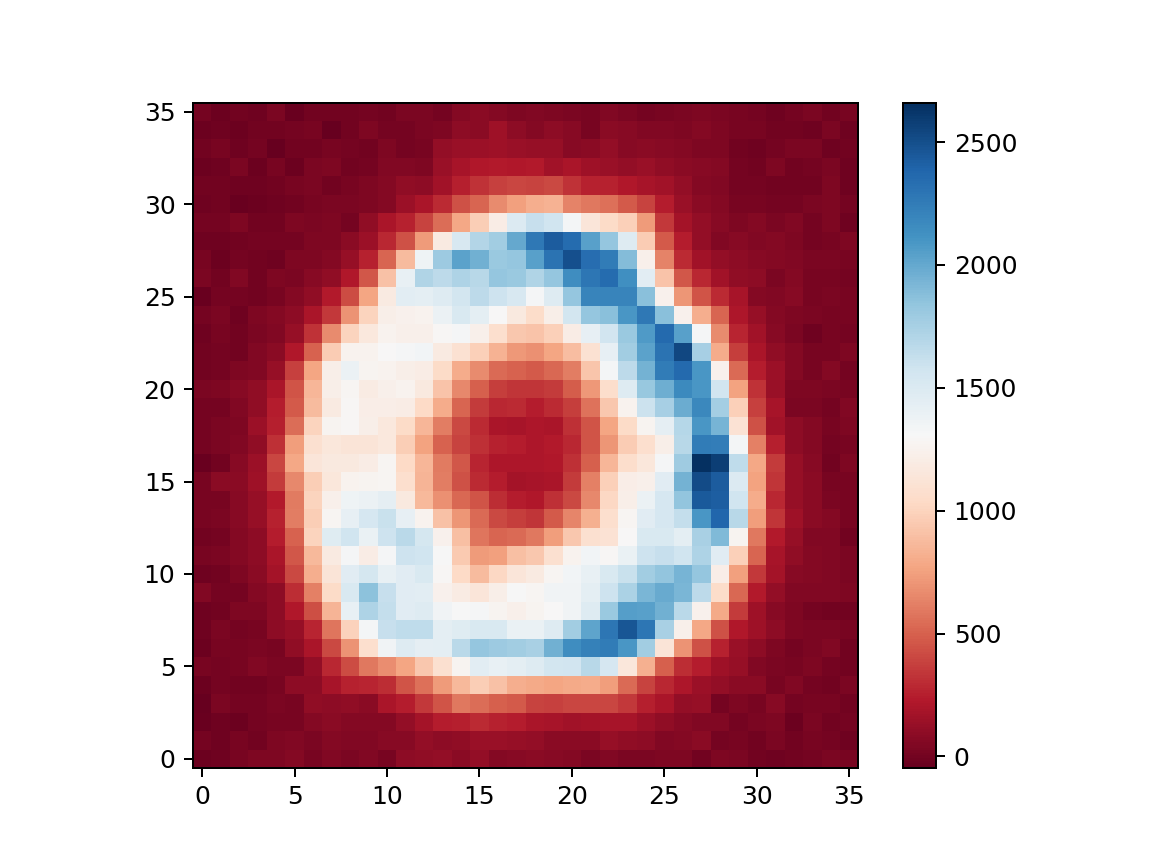

In [342]:
fig, ax = plt.subplots()
im = ax.imshow(I1.image, origin='lower', cmap='RdBu')
cbar = fig.colorbar(im)
fig.show()

In [343]:
kuiper = Instrument('61inch', I1.sizeinPix)

In [344]:
# this is a hack. 0.0 doesn't work, but this will yield annular zernike solution that is very close to circular.
#kuiper.obscuration = 0.01

In [345]:
algo = Algorithm('exp', kuiper, 3)

In [346]:
algo.runIt(kuiper, I1, I2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   18.95,   17.18)

imageCoCenter: (x1,y1)=(   16.25,   17.92)

itr = 0, z4-z22
[-176.  -63.  141.   28.   64.  116.   52.   14.  -13.   11.  -11.    4.
    1.    1.   -6.  -13.   -4.   -6.    6.]
itr = 1, z4-z22
[-181.  -52.  146.   17.   65.  114.   44.   14.  -13.    9.  -11.    3.
    1.    4.   -5.  -14.   -4.   -6.    1.]
itr = 2, z4-z22
[-189.  -48.  149.   24.   69.  112.   39.   12.  -15.    7.  -13.    2.
   -5.   -1.   -5.  -13.   -5.   -6.    0.]
itr = 3, z4-z22
[-207.  -74.  144.   25.   65.  111.   43.   11.   -9.    8.  -11.    4.
   -2.   -3.   -5.  -13.   -4.   -7.    0.]
itr = 4, z4-z22
[-200.  -45.  173.   29.   64.  114.   38.   13.   -8.    3.  -11.    3.
   -0.   -4.   -4.  -13.   -4.   -6.   -2.]
itr = 5, z4-z22
[-191.  -50.  164.   24.   60.  130.   42.   15.   -8.    6.  -12.    3.
    2.   -1.   -3.   -9.   -5.   -4.   -1.]
itr = 6, z4-z22
[-184.  -52.  159.   22.   59.  139.   44.   16.   -8.    7.  -13.    

In [347]:
print(algo.zer4UpNm)

[-166.87506449  -60.70334319  130.39248861   15.93479426   58.96989963
  128.5413394    43.87600288   16.77772691   -6.71798462   12.23362476
  -19.41756159   10.04240312    1.00178511    2.02708032   -5.12741789
   -8.21793623   -9.62279287   -6.7542294     4.66885777]


In [261]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [348]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()

In [279]:
#zv.save("star1.zern")

<IPython.core.display.Javascript object>


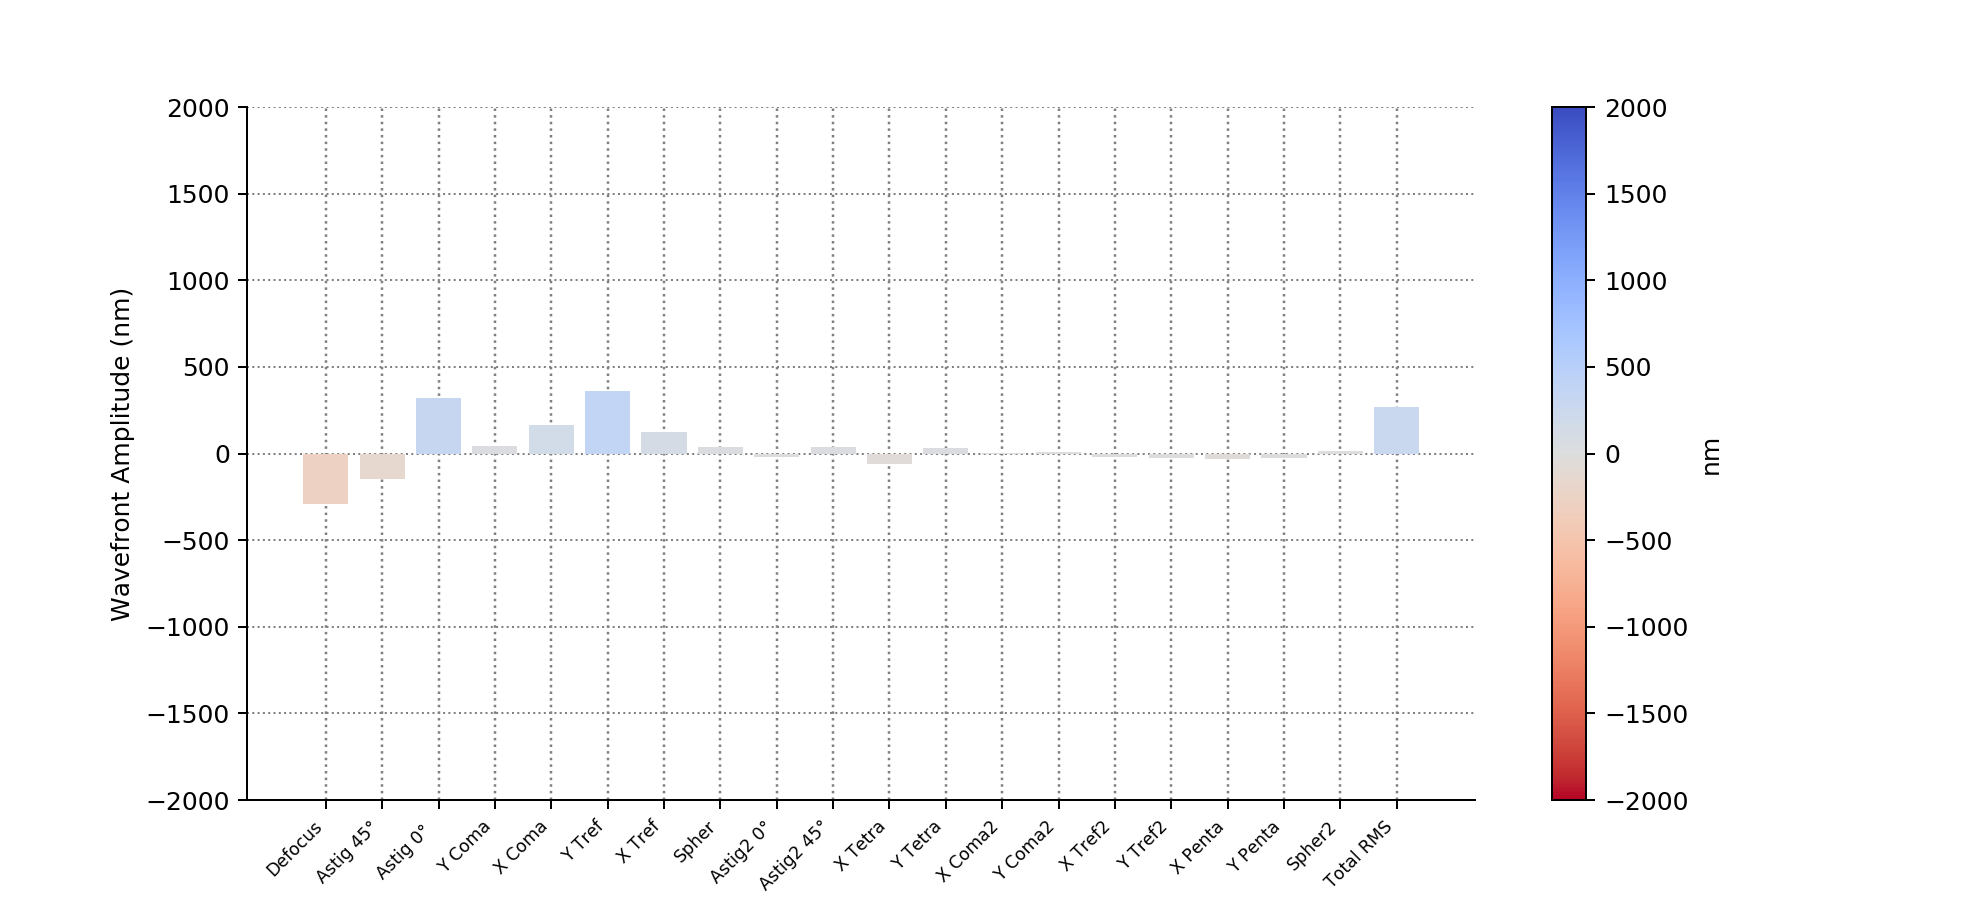

In [349]:
zv.fringe_bar_chart().show()

In [133]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

<IPython.core.display.Javascript object>


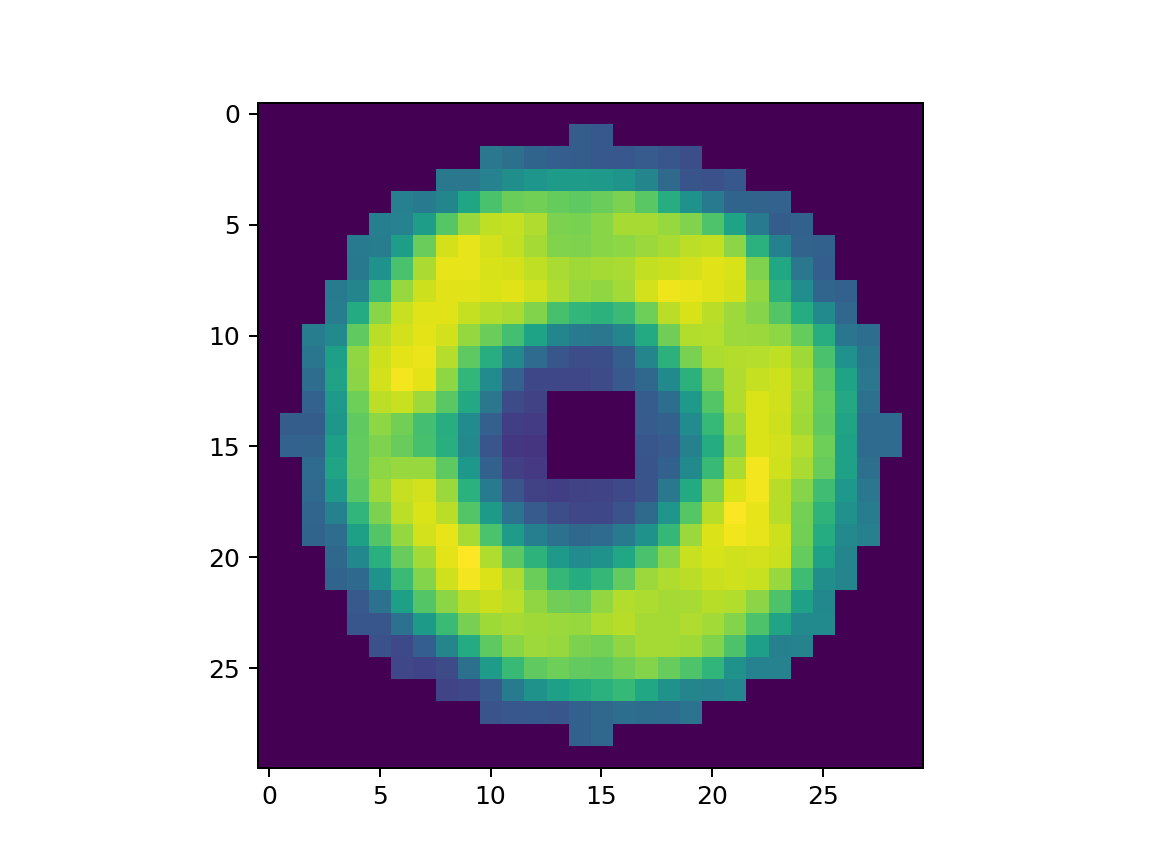

In [173]:
plt.imshow(algo.image)
plt.show()

In [33]:
plt.close('all')

In [34]:
mmt.offset

0.0188

In [43]:
fig, ax = plt.subplots()

In [18]:
plt.imshow(algo.Wconverge, origin="lower")
plt.show()

NameError: name 'algo' is not defined

##### -15" of CC_Y went to +15" of CC_X; +10" of CC_X went to -10" of CC_Y

In [45]:
ax.set_title?

<IPython.core.display.Javascript object>


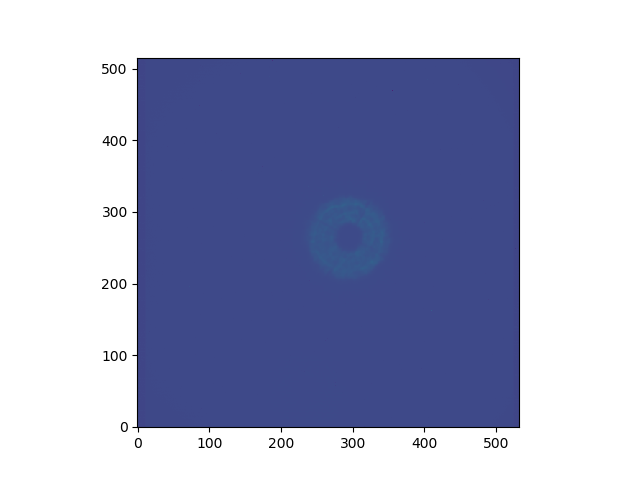

In [5]:
im = fits.open("/Users/tim/MMT/wfsdat/20180209/sog_ff_cal_img_2018.0209.021854.fits")[-1].data
plt.imshow(im, origin='lower')
plt.show()

In [11]:
t = MMT()
pup_mask = t.pupil_mask(size=120)
x, y, f = center_pupil(im, pup_mask, threshold=0.8)

In [12]:
x, y

(294.17391943616093, 264.1331285222056)

<IPython.core.display.Javascript object>


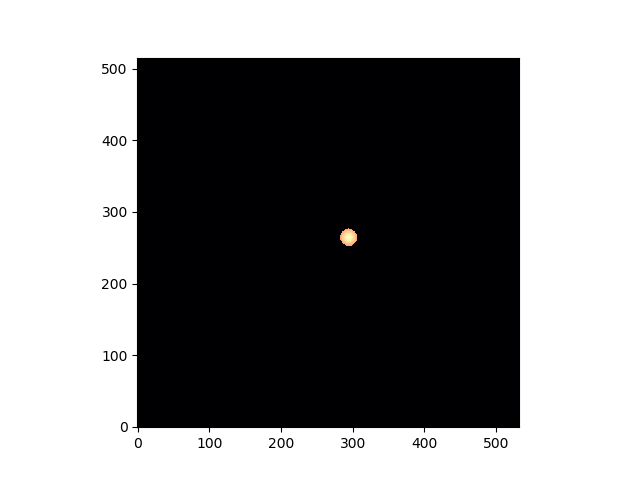

In [13]:
f.show()

In [153]:
5.4**2 / 1.25**2

18.6624

Scaling seems wrong so try to calculate offset for MMT same way...

In [203]:
pupsize = 135. * 26.
diameter = 6.5 * u.m
radius = diameter / 2.
focal_length = diameter * 5.3
ang = np.arctan2(radius, focal_length)
offset = 0.5 * pupsize / np.tan(ang) * u.um
offset

<Quantity 18603. um>

OK, this matches what we're using there.